In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os
import random
from tqdm import tqdm
import cv2
from skimage.io import imread,imshow
from skimage.transform import resize
from tensorflow.keras import backend as K
import tensorflow_addons as tfa

C:\ProgramData\Anaconda3\envs\py37\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [3]:
# from tensorflow.python.ops.numpy_ops import np_config
# np_config.enable_numpy_behavior()

In [4]:
TRAIN_PATH = "dataset/2d_slices/pre_processed_images/"
TRAIN_MASK_PATH = "dataset/2d_slices/masks/"
MODEL_SAVE = "model/"

In [5]:
train_ids = next(os.walk(TRAIN_PATH))[2]
mask_train_ids = next(os.walk(TRAIN_MASK_PATH))[2]

In [6]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

In [7]:
X_train = np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_train=np.zeros((len(mask_train_ids),IMG_HEIGHT,IMG_WIDTH,1),dtype = np.float16)

In [8]:
for n,id_ in tqdm(enumerate(train_ids),total=len(train_ids)):
    path=TRAIN_PATH+"/"+id_
    img = np.load(path)
    img = resize(img,(IMG_HEIGHT,IMG_WIDTH),mode="constant",preserve_range=True)
    X_train[n]=np.expand_dims(img, axis=2)

100%|██████████████████████████████████████████████████████████████████████████████| 1176/1176 [00:19<00:00, 59.62it/s]


In [9]:
for n,id_ in tqdm(enumerate(mask_train_ids),total=len(mask_train_ids)):
    path=TRAIN_MASK_PATH+"/"+id_
    mask = np.load(path)
    mask = resize(mask,(IMG_HEIGHT,IMG_WIDTH),mode="constant",preserve_range=True)
    Y_train[n]=np.expand_dims(mask, axis=2)

100%|██████████████████████████████████████████████████████████████████████████████| 1176/1176 [00:20<00:00, 56.60it/s]


C:\ProgramData\Anaconda3\envs\py37\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
C:\ProgramData\Anaconda3\envs\py37\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


Smallest pixel in image is [24]
Largest pixel in image is [255]
Smallest pixel in mask is [0.]
Largest pixel in mask is [1.]


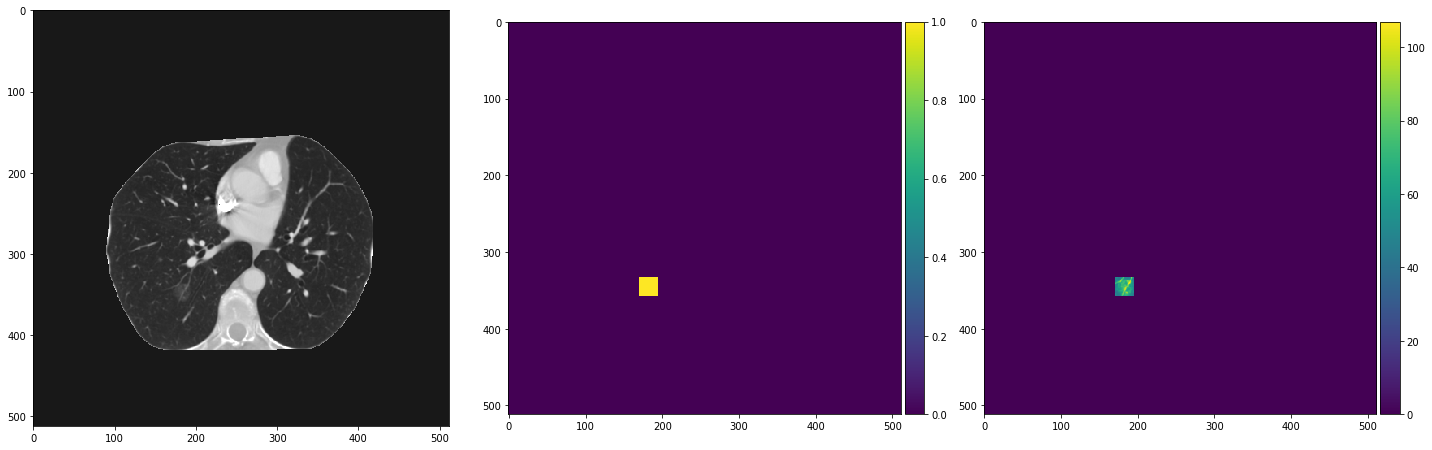

In [10]:
#Checking the training data
ix=random.randint(0,len(train_ids))
plt.figure(figsize=[20,10])
plt.subplot(131)
imshow(X_train[ix])
plt.subplot(132)
imshow(Y_train[ix])
plt.subplot(133)
imshow((X_train[ix])*Y_train[ix])
smallest = X_train[ix].min(axis=(0, 1))
largest = X_train[ix].max(axis=(0, 1))
print("Smallest pixel in image is",smallest)
print("Largest pixel in image is", largest)
smallest = Y_train[ix].min(axis=(0, 1))
largest = Y_train[ix].max(axis=(0, 1))
print("Smallest pixel in mask is",smallest)
print("Largest pixel in mask is", largest)


In [11]:
#https://stackoverflow.com/questions/72195156/correct-implementation-of-dice-loss-in-tensorflow-keras
# def dice_coef(y_true, y_pred, smooth = 100):        
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
#     return dice
def dice_coef(y_true, y_pred, smooth = 1e-5):
    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred), axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice_scores_tensor = (2. * intersection + smooth) / (union + smooth)
    mean_dice_score = tf.reduce_mean(dice_scores_tensor)
    return mean_dice_score

In [12]:
def dice_coef_loss_and_bce(y_true, y_pred):
    dice_loss = 1- dice_coef(y_true, y_pred) 
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    term_0 = (1 - y_true) * K.log(1 - y_pred + K.epsilon())  
    term_1 = y_true * K.log(y_pred + K.epsilon())
    bce_loss = -K.mean(term_0 + term_1, axis=0)
    mean = 0.5*(dice_loss + bce_loss)
    return mean

In [13]:
inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))

In [14]:
s = tf.keras.layers.Lambda(lambda x:x / 255)(inputs)

### Constructing U NET

In [15]:
c1 = tf.keras.layers.Conv2D(16,(3,3),activation="relu",kernel_initializer = "he_normal",padding="same")(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c1)
p1=tf.keras.layers.MaxPooling2D((2,2))(c1)

In [16]:
c2=tf.keras.layers.Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2=tf.keras.layers.Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c2)
p2= tf.keras.layers.MaxPooling2D((2,2))(c2)

In [17]:
c3=tf.keras.layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p2)
c3=tf.keras.layers.Dropout(0.2)(c3)
c3=tf.keras.layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c3)
p3=tf.keras.layers.MaxPooling2D((2,2))(c3)

In [18]:
c4=tf.keras.layers.Conv2D(128,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p3)
c4=tf.keras.layers.Dropout(0.2)(c4)
c4=tf.keras.layers.Conv2D(126,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c4)
p4=tf.keras.layers.MaxPooling2D((2,2))(c4)

In [19]:
c5=tf.keras.layers.Conv2D(256,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p4)
c5=tf.keras.layers.Dropout(0.3)(c5)
c5=tf.keras.layers.Conv2D(256,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c5)
p5=tf.keras.layers.MaxPooling2D((2,2))(c5)

In [20]:
#expansive path

In [21]:
u6 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding="same")(c5)
u6=tf.keras.layers.concatenate([u6,c4])
c6=tf.keras.layers.Conv2D(128,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u6)
c6=tf.keras.layers.Dropout(0.2)(c6)
c6=tf.keras.layers.Conv2D(128,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c6)

In [22]:
u7=tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding="same")(c6)
u7=tf.keras.layers.concatenate([u7,c3])
c7=tf.keras.layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u7)
c7=tf.keras.layers.Dropout(0.2)(c7)
c7=tf.keras.layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c7)

In [23]:
u8 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding="same")(c7)
u8=tf.keras.layers.concatenate([u8,c2])
c8=tf.keras.layers.Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u8)
c8=tf.keras.layers.Dropout(0.1)(c8)
c8=tf.keras.layers.Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c8)


In [24]:
u9=tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding="same")(c8)
u9=tf.keras.layers.concatenate([u9,c1],axis=3)
c9=tf.keras.layers.Conv2D(16,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u9)
c9=tf.keras.layers.Dropout(0.1)(c9)
c9=tf.keras.layers.Conv2D(16,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c9)


In [25]:
outputs=tf.keras.layers.Conv2D(1,(1,1),activation="sigmoid")(c9)

In [26]:
#https://towardsdatascience.com/dealing-with-class-imbalanced-image-datasets-1cbd17de76b5
model_unet=tf.keras.Model(inputs=[inputs],outputs=[outputs])
model_unet.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00003),loss=dice_coef_loss_and_bce,metrics=[dice_coef])
model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 16  0           ['conv2d[0][0]']                 
                                )                                                             

 spose)                         )                                                                 
                                                                                                  
 concatenate_2 (Concatenate)    (None, 256, 256, 64  0           ['conv2d_transpose_2[0][0]',     
                                )                                 'conv2d_3[0][0]']               
                                                                                                  
 conv2d_14 (Conv2D)             (None, 256, 256, 32  18464       ['concatenate_2[0][0]']          
                                )                                                                 
                                                                                                  
 dropout_7 (Dropout)            (None, 256, 256, 32  0           ['conv2d_14[0][0]']              
                                )                                                                 
          

C:\Users\amit\AppData\Roaming\Python\Python37\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [27]:
checkpointer= tf.keras.callbacks.ModelCheckpoint("./model/lungnodule_vanilla.h5",verbose=1,save_best_only=True)

In [28]:
callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=10,monitor="val_dice_coef"),
    tf.keras.callbacks.TensorBoard(log_dir="logs"),
    checkpointer
]

In [ ]:
 results = model_unet.fit(X_train,Y_train,validation_split=0.2,batch_size=8,epochs=200,callbacks=callbacks )

Epoch 1/200
118/118 [==============================] - ETA: 0s - loss: 0.5172 - dice_coef: 0.0016
Epoch 1: val_loss improved from inf to 0.50894, saving model to ./model\lungnodule_vanilla.h5
118/118 [==============================] - 1145s 10s/step - loss: 0.5172 - dice_coef: 0.0016 - val_loss: 0.5089 - val_dice_coef: 1.8513e-07
Epoch 2/200
118/118 [==============================] - ETA: 0s - loss: 0.5079 - dice_coef: 6.8134e-04
Epoch 2: val_loss improved from 0.50894 to 0.50876, saving model to ./model\lungnodule_vanilla.h5
118/118 [==============================] - 1188s 10s/step - loss: 0.5079 - dice_coef: 6.8134e-04 - val_loss: 0.5088 - val_dice_coef: 2.5693e-07
Epoch 3/200
 45/118 [==========>...................] - ETA: 12:08 - loss: 0.5084 - dice_coef: 3.8626e-04

#### Checking the model on random images

In [ ]:
idx = random.randint(0,len(X_train))

In [ ]:
preds_train = model_unet.predict(X_train[:int(X_train.shape[0]*0.9)],verbose=1)
preds_val = model_unet.predict(X_train[int(X_train.shape[0]*0.9):],verbose=1)
#preds_test=model_unet.predict(X_t,verbose=1)

In [ ]:
#Each pixel is given a value between 0 and 1. We set a threshold 0.5 to binarize using thresholding

In [ ]:
preds_train_t = (preds_train >0.6).astype(np.uint8)
preds_val_t = (preds_val>0.6).astype(np.uint8)
#preds_test_t = (preds_test>0.6).astype(np.uint8)

In [ ]:
#Checking

In [ ]:
ix = random.randint(0,len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(Y_train[ix])
plt.show()
imshow(preds_train_t[ix])
plt.show()